In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_pickle("../data/cleaned/combined.pkl")
df.head()

,order_id,customer_name,restaurant_id,order_date,quantity_of_items,order_amount,payment_mode,delivery_time_taken_(mins),customer_rating_food,customer_rating_delivery,day,hour,weekday,month,is_weekend,restaurant_name,cuisine,zone,category
0,OD1,srini,6,2022-01-01 23:15:00,5,633,debit_card,47,5,3,2022-01-01,23,5,1,weekend,willies,french,zone_d,pro
1,OD2,revandh,13,2022-01-01 19:21:00,5,258,credit_card,41,3,5,2022-01-01,19,5,1,weekend,veer_restaurant,chinese,zone_d,ordinary
2,OD3,david,9,2022-01-01 23:15:00,7,594,cash_on_delivery,30,3,4,2022-01-01,23,5,1,weekend,excel_restaurant,north_indian,zone_d,ordinary
3,OD4,selva,4,2022-01-01 20:31:00,5,868,cash_on_delivery,30,3,4,2022-01-01,20,5,1,weekend,win_hotel,south_indian,zone_d,ordinary
4,OD5,vinny,4,2022-01-01 11:10:00,4,170,debit_card,18,4,3,2022-01-01,11,5,1,weekend,win_hotel,south_indian,zone_d,ordinary


In [3]:
# Group data by hour and calculate important metrics
hourly_agg = df.groupby('hour').agg(
    total_orders=('order_id', 'count'),
    total_items=('quantity_of_items', 'sum'),
    total_revenue=('order_amount', 'sum'),
    avg_delivery_time=('delivery_time_taken_(mins)', 'mean')
).reset_index()

hourly_agg


,hour,total_orders,total_items,total_revenue,avg_delivery_time
0,11,73,357,47296,29.438356
1,12,41,197,23246,29.146341
2,13,54,237,30749,31.666667
3,14,99,446,58673,29.212121
4,15,23,109,14406,30.217391
5,17,20,89,10691,31.450000
6,18,18,78,10589,34.444444
7,19,31,131,14730,36.548387
8,20,49,246,31879,29.897959
9,21,31,152,21534,31.774194


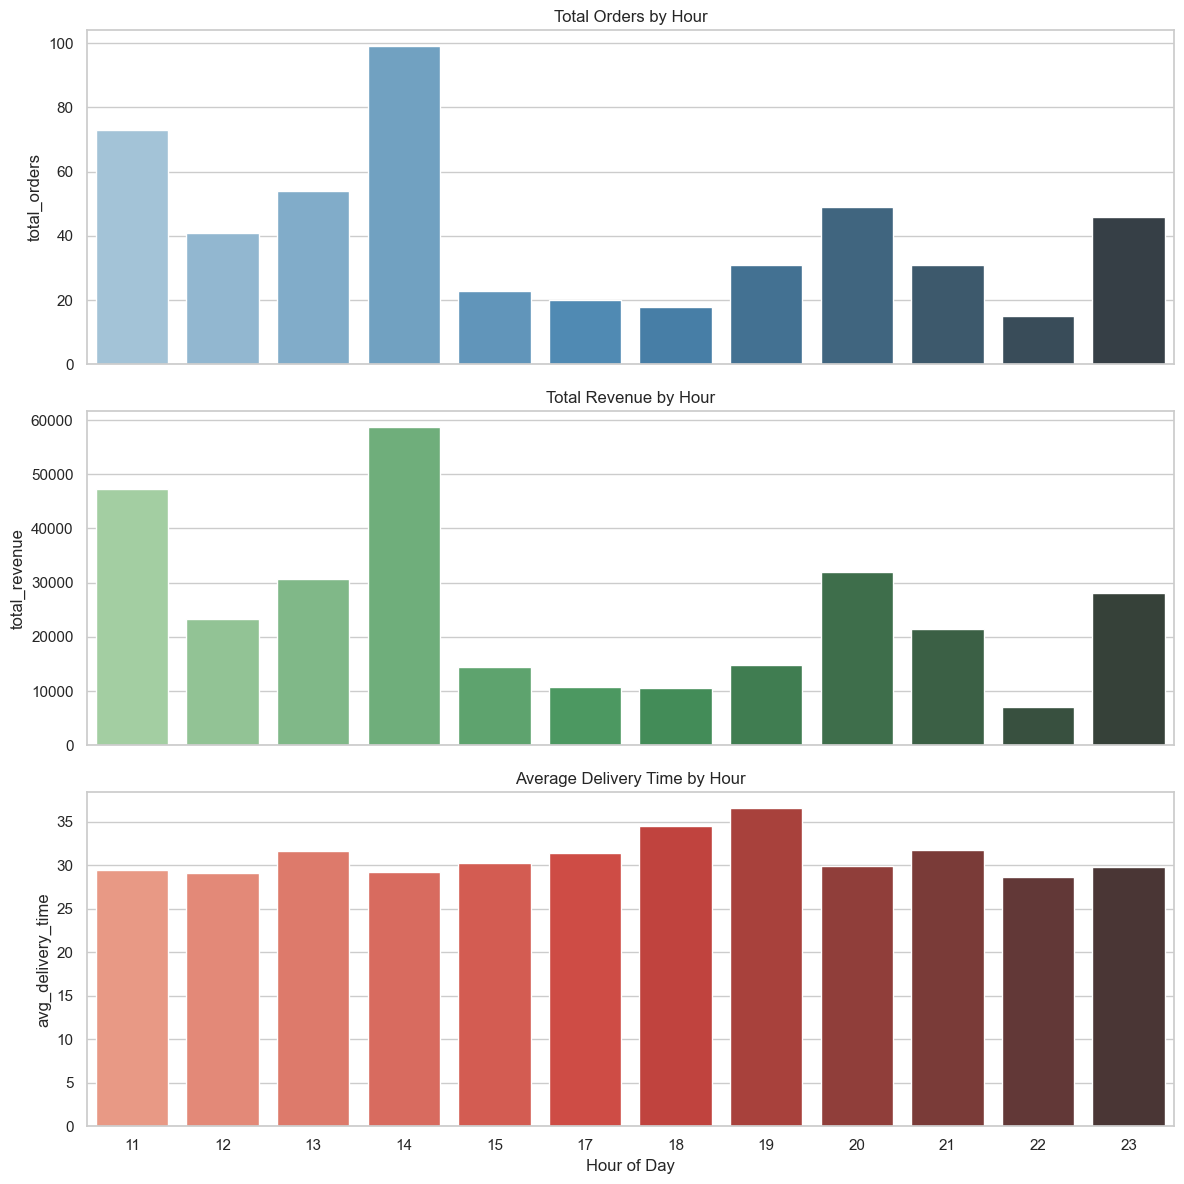

In [4]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

sns.barplot(x='hour', y='total_orders', data=hourly_agg, ax=axes[0], palette="Blues_d")
axes[0].set_title("Total Orders by Hour")

sns.barplot(x='hour', y='total_revenue', data=hourly_agg, ax=axes[1], palette="Greens_d")
axes[1].set_title("Total Revenue by Hour")

sns.barplot(x='hour', y='avg_delivery_time', data=hourly_agg, ax=axes[2], palette="Reds_d")
axes[2].set_title("Average Delivery Time by Hour")
axes[2].set_xlabel("Hour of Day")

plt.tight_layout()
plt.show()

In [5]:
# Split by time: use early hours to predict later hours
train_data = hourly_agg[hourly_agg['hour'] < 18]  # hours 0–17
test_data = hourly_agg[hourly_agg['hour'] >= 18]  # hours 18–23

X_train = train_data[['total_items', 'total_revenue', 'avg_delivery_time']]
y_train = train_data['total_orders']
X_test = test_data[['total_items', 'total_revenue', 'avg_delivery_time']]
y_test = test_data['total_orders']

In [6]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [7]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 4.92
R² Score: 0.73


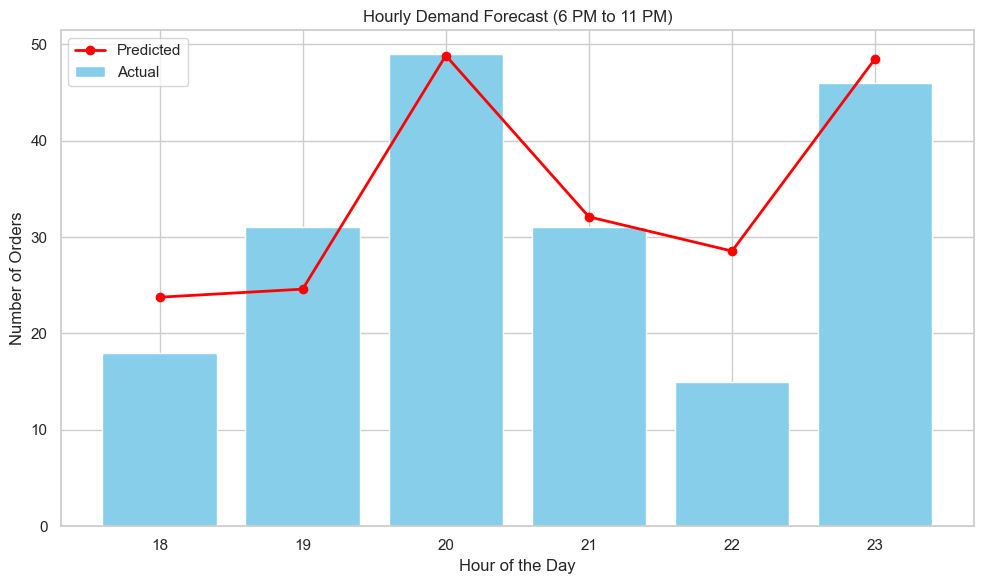

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(test_data['hour'], y_test, label='Actual', color='skyblue')
plt.plot(test_data['hour'], y_pred, label='Predicted', color='red', linewidth=2, marker='o')
plt.title("Hourly Demand Forecast (6 PM to 11 PM)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Orders")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

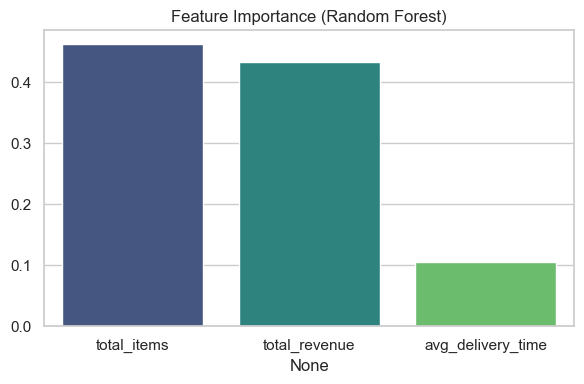

In [9]:
importances = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(6, 4))
sns.barplot(y=importances, x=features, palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()